In [1]:
# Imports & Configuration
# ======================
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import json

In [2]:
# Configuration
SEED = 42
IMG_SIZE = (128, 128)  # Increased from 64x64
BATCH_SIZE = 32
EPOCHS = 30
DATA_PATH = "D:/DATASETS/EUROSAT/EuroSAT"
CLASS_NAMES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 
              'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 
              'River', 'SeaLake']

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [49]:
# List all land type categories
# ✅ Redefine categories to exclude files like label_map.json
categories = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))]
categories

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

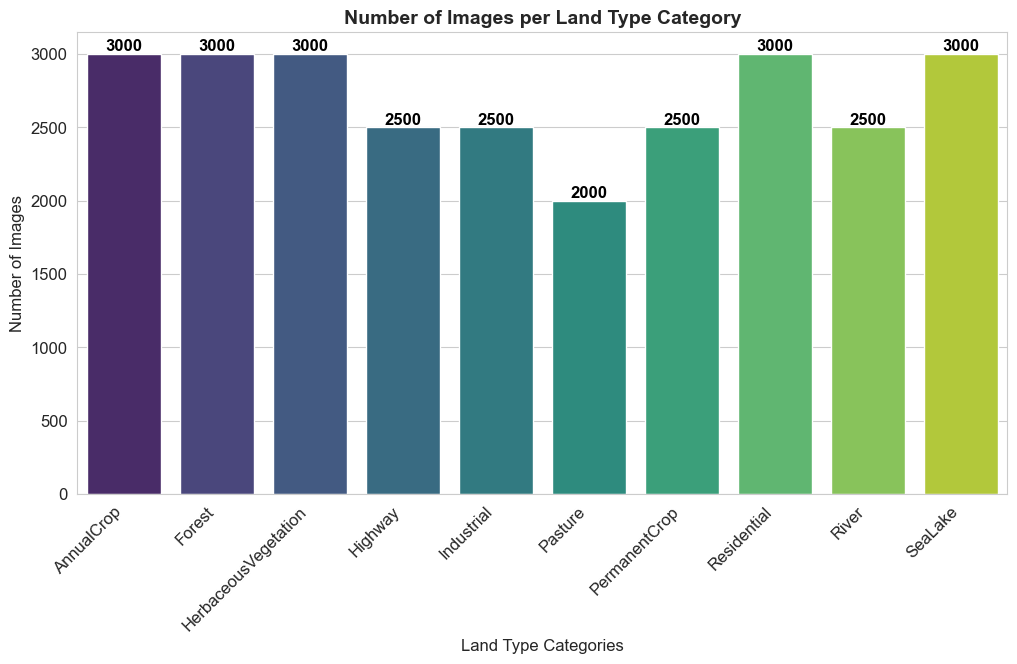

In [51]:
# Count the number of images per category
image_count = {}
for category in categories:
    category_path = os.path.join(DATA_PATH, category)
    if os.path.isdir(category_path):  # Check if it's a directory
        image_count[category] = len(os.listdir(category_path))
    else:
        print(f"Skipping {category_path} as it is not a directory.")

# Set Seaborn style
sns.set_style("whitegrid")

# Create the bar plot (fix: assign `x` to `hue` and disable legend)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(image_count.keys()), y=list(image_count.values()), hue=list(image_count.keys()), palette="viridis", legend=False)

# Add exact counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title('Number of Images per Land Type Category', fontsize=14, fontweight='bold')
plt.xlabel('Land Type Categories', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Show the plot
plt.show()

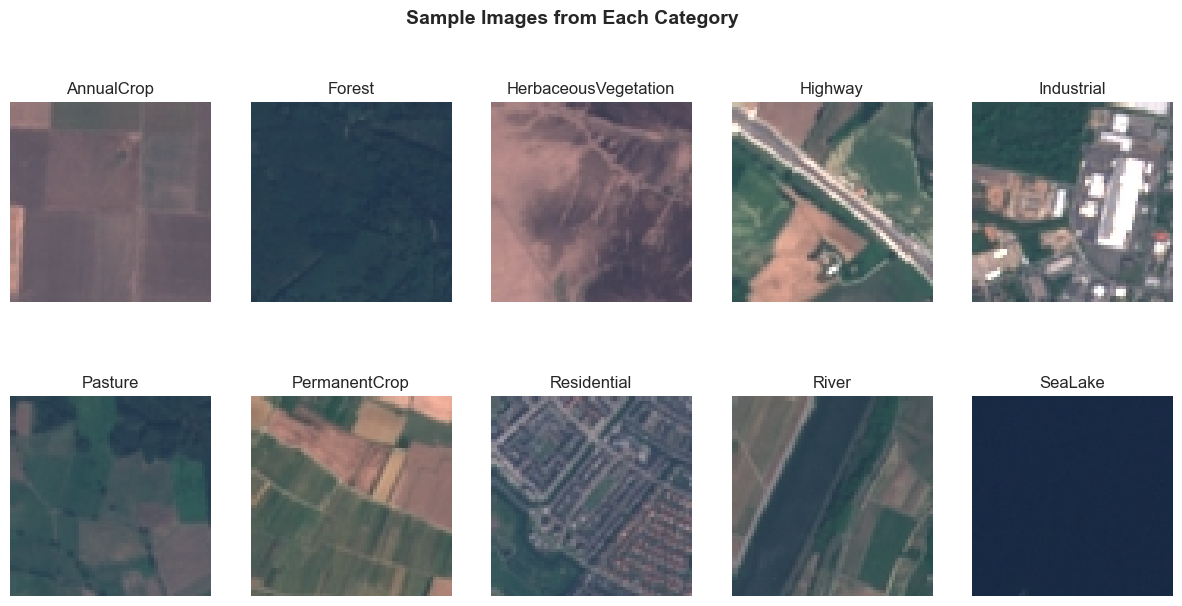

In [53]:
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
for i, category in enumerate(categories):
    category_path = os.path.join(DATA_PATH, category)
    sample_image = os.listdir(category_path)[0]
    img = Image.open(os.path.join(category_path, sample_image))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')

plt.suptitle('Sample Images from Each Category', fontsize=14, fontweight='bold')
plt.show()


In [3]:
# Enhanced Data Preparation
# ======================
def create_datagen(augmentation=True):
    """Create data generators with enhanced augmentation"""
    if augmentation:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.3,
            horizontal_flip=True,
            brightness_range=[0.7, 1.3],
            fill_mode='nearest',
            validation_split=0.2
        )
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)
        
    return train_datagen

def get_data_generators():
    """Create train/validation/test generators"""
    train_datagen = create_datagen(augmentation=True)
    test_datagen = create_datagen(augmentation=False)

    train_generator = train_datagen.flow_from_directory(
        DATA_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        seed=SEED,
        classes=CLASS_NAMES
    )

    val_generator = train_datagen.flow_from_directory(
        DATA_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        seed=SEED,
        classes=CLASS_NAMES
    )

    test_generator = test_datagen.flow_from_directory(
        DATA_PATH,
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle=False,
        classes=CLASS_NAMES
    )
    
    # Save class indices for deployment
    with open('class_indices.json', 'w') as f:
        json.dump(train_generator.class_indices, f)
        
    return train_generator, val_generator, test_generator

In [4]:
# Improved Model Architecture
# ======================
def create_model():
    """Create enhanced CNN model with preprocessing layers"""
    model = models.Sequential([
        # Input preprocessing
        preprocessing.Rescaling(1./255, input_shape=(*IMG_SIZE, 3)),
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(0.1),
        
        # Convolutional Base
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.GlobalAveragePooling2D(),
        
        # Classifier
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(CLASS_NAMES), activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [17]:
# Training Callbacks
# ======================
def get_callbacks():
    """Create and return a list of training callbacks"""
    return [
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=3),
        callbacks.TensorBoard(log_dir='./logs')
    ]

In [19]:
# Visualization Functions
# ======================
def plot_training_history(history):
    """Plot training and validation metrics"""
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(14, 5))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


In [21]:
def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot enhanced confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

In [23]:
if __name__ == "__main__":
    # Data preparation
    print("Preparing data generators...")
    train_gen, val_gen, test_gen = get_data_generators()
    print("Data generators created successfully!")

Preparing data generators...
Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Found 27000 images belonging to 10 classes.
Data generators created successfully!


In [24]:
# Model Creation Cell
# ======================
if __name__ == "__main__":
    # Model creation
    print("\nCreating model architecture...")
    model = create_model()
    model.summary()


Creating model architecture...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 128, 128, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooli

In [27]:
# Training Cell
# ======================
if __name__ == "__main__":
    # Training
    print("\nStarting model training...")
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=get_callbacks()
    )
    print("\nTraining completed!")



Starting model training...
Epoch 1/30
675/675 [==============================] - 178s 255ms/step - loss: 1.2563 - accuracy: 0.5485 - val_loss: 15.7256 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 2/30
675/675 [==============================] - 174s 258ms/step - loss: 0.8695 - accuracy: 0.6908 - val_loss: 14.7458 - val_accuracy: 0.0931 - lr: 0.0010
Epoch 3/30
675/675 [==============================] - 134s 199ms/step - loss: 0.7542 - accuracy: 0.7318 - val_loss: 20.8373 - val_accuracy: 0.2219 - lr: 0.0010
Epoch 4/30
675/675 [==============================] - 136s 201ms/step - loss: 0.6734 - accuracy: 0.7647 - val_loss: 54.3363 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 5/30
675/675 [==============================] - 144s 213ms/step - loss: 0.6270 - accuracy: 0.7818 - val_loss: 17.2178 - val_accuracy: 0.2417 - lr: 0.0010
Epoch 6/30
675/675 [==============================] - 137s 203ms/step - loss: 0.5094 - accuracy: 0.8250 - val_loss: 3.2076 - val_accuracy: 0.4391 - lr: 1.0000e-04
Epoch 7/3

In [29]:
# Model Saving Cell
# ======================
if __name__ == "__main__":
    # Save final model
    print("\nSaving trained model...")
    model.save('eurosat_model.keras')
    print("Model saved successfully as 'eurosat_model.keras'")



Saving trained model...
Model saved successfully as 'eurosat_model.keras'



Generating training history plots...


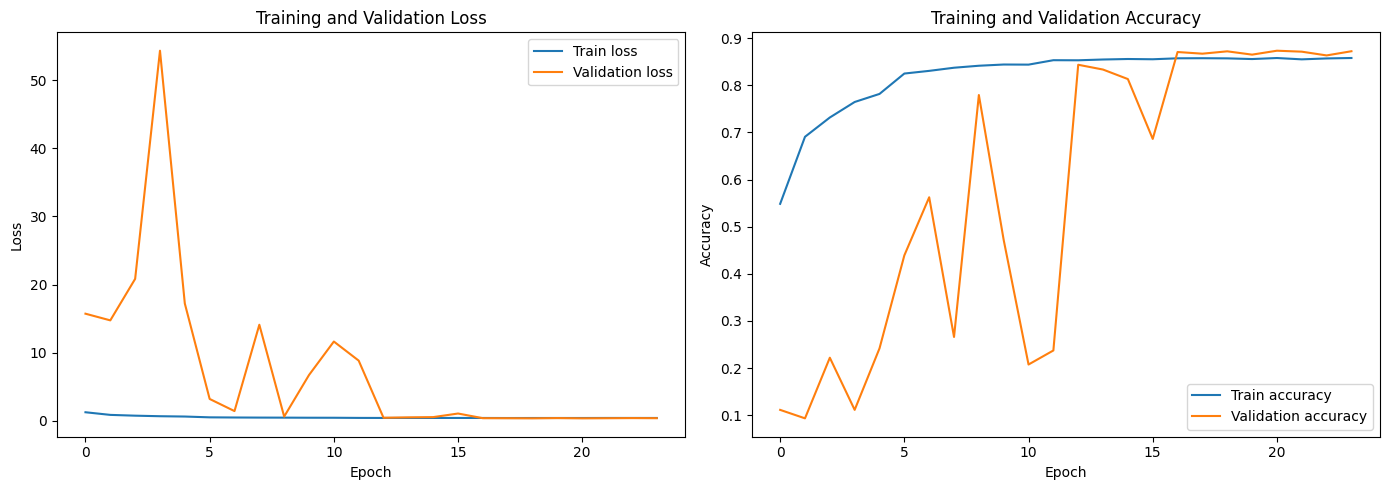

In [31]:
# Visualization Cell
# ======================
if __name__ == "__main__":
    # Visualization
    print("\nGenerating training history plots...")
    plot_training_history(history)

In [33]:
# Evaluation Cell
# ======================
if __name__ == "__main__":
    # Evaluation
    print("\nEvaluating on test set...")
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")


Evaluating on test set...
27000/27000 [==============================] - 85s 3ms/step - loss: 0.2996 - accuracy: 0.8957

Test Accuracy: 0.8957
Test Loss: 0.2996



Generating confusion matrix...
27000/27000 [==============================] - 46s 2ms/step


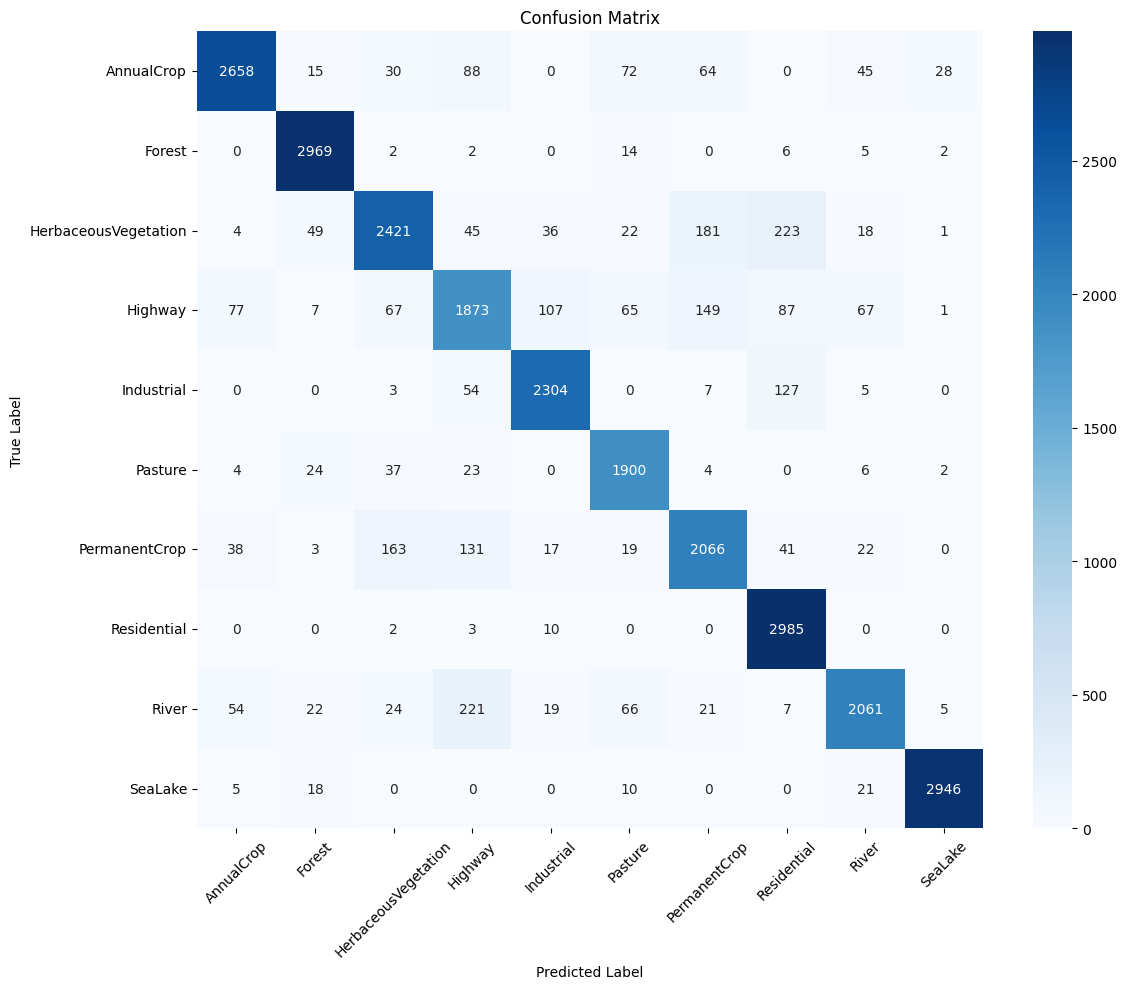

In [35]:
# Confusion Matrix Cell
# ======================
if __name__ == "__main__":
    # Confusion Matrix
    print("\nGenerating confusion matrix...")
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    y_true = test_gen.labels
    plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)

In [37]:
# Classification Report Cell
# ======================
if __name__ == "__main__":
    # Classification Report
    print("\nGenerating classification report...")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


Generating classification report...
                      precision    recall  f1-score   support

          AnnualCrop       0.94      0.89      0.91      3000
              Forest       0.96      0.99      0.97      3000
HerbaceousVegetation       0.88      0.81      0.84      3000
             Highway       0.77      0.75      0.76      2500
          Industrial       0.92      0.92      0.92      2500
             Pasture       0.88      0.95      0.91      2000
       PermanentCrop       0.83      0.83      0.83      2500
         Residential       0.86      0.99      0.92      3000
               River       0.92      0.82      0.87      2500
             SeaLake       0.99      0.98      0.98      3000

            accuracy                           0.90     27000
           macro avg       0.89      0.89      0.89     27000
        weighted avg       0.90      0.90      0.89     27000

